In [17]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip3 install torchrl
!pip3 install "gymnasium[mujoco]"
!pip3 install -U 'mujoco-py<2.2,>=2.1'
!pip3 install tqdm

In [97]:
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torch.nn.utils import clip_grad_norm_
from torchrl.collectors import SyncDataCollector
from torchrl.data import ReplayBuffer
from torchrl.data.replay_buffers import LazyTensorStorage, SamplerWithoutReplacement
from torchrl.envs import ObservationNorm, TransformedEnv, Compose, DoubleToFloat, StepCounter
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else
    'cpu'
)

In [11]:
MODEL_SIZE = 256
BATCH_SIZE = 1000
SUB_BATCH_SIZE = 64
LEARNING_RATE = 3e-4
MAX_GRAD_NORM = 1.0
MAX_FRAME_NUMBER = 50_000
EPOCHS = 10
CLIP_EPSILON = (0.2)
GAMMA = 0.99
LAMBDA = 0.95
ENTROPY_EPS = 1e-4

# Environment definition

In [42]:
observation_keys = ['observation']
base_env = GymEnv('InvertedDoublePendulum-v4', device=device)
env = TransformedEnv(
    base_env,
    Compose(
        # normalise onservations
        ObservationNorm(in_keys=observation_keys),
        DoubleToFloat(),
        StepCounter(),
    ),
)
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
print('env:', env)
print('normalisation shape:', env.transform[0].loc.shape)

env: TransformedEnv(
    env=GymEnv(env=InvertedDoublePendulum-v4, batch_size=torch.Size([]), device=cpu),
    transform=Compose(
            ObservationNorm(keys=['observation']),
            DoubleToFloat(in_keys=['observation'], out_keys=['observation'], in_keys_inv=[], out_keys_inv=[]),
            StepCounter(keys=[])))
normalisation shape: torch.Size([11])


In [43]:
# environment specs
print('observation spec:', env.observation_spec)
print('reward spec:', env.reward_spec)
print('inpput spec:', env.input_spec)
print('action spec:', env.action_spec)

observation spec: Composite(
    observation: UnboundedContinuous(
        shape=torch.Size([11]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=discrete),
    device=cpu,
    shape=torch.Size([]),
    data_cls=None)
reward spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),

In [44]:
# ensure specs are properly defined
check_env_specs(env)

2026-02-09 15:35:00,380 [torchrl][INFO]    check_env_specs succeeded! [END]


In [45]:
rollout = env.rollout(3)
rollout

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([3]),
            device=cpu,
            is_s

#Policy network definition

In [64]:
n_actions = env.action_spec.shape[-1]

actor_net = nn.Sequential(
    nn.LazyLinear(MODEL_SIZE, device=device),
    nn.Tanh(),
    nn.LazyLinear(MODEL_SIZE, device=device),
    nn.Tanh(),
    nn.LazyLinear(MODEL_SIZE, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * n_actions, device=device),
    NormalParamExtractor(),
)

norm_dict_keys = ['loc', 'scale']
policy = TensorDictModule(actor_net, in_keys=observation_keys, out_keys=norm_dict_keys)
policy_net = ProbabilisticActor(
    module=policy,
    spec=env.action_spec,
    in_keys=norm_dict_keys,
    distribution_class=TanhNormal,
    distribution_kwargs={
        'low': env.action_spec.space.low,
        'high': env.action_spec.space.high,
    },
    return_log_prob=True,
)
policy_net

ProbabilisticActor(
    module=ModuleList(
      (0): TensorDictModule(
          module=Sequential(
            (0): LazyLinear(in_features=0, out_features=256, bias=True)
            (1): Tanh()
            (2): LazyLinear(in_features=0, out_features=256, bias=True)
            (3): Tanh()
            (4): LazyLinear(in_features=0, out_features=256, bias=True)
            (5): Tanh()
            (6): LazyLinear(in_features=0, out_features=2, bias=True)
            (7): NormalParamExtractor(
              (scale_mapping): biased_softplus()
            )
          ),
          device=cpu,
          in_keys=['observation'],
          out_keys=['loc', 'scale'])
      (1): SafeProbabilisticModule(
          in_keys=['loc', 'scale'],
          out_keys=['action', 'action_log_prob'],
          distribution_class=<class 'torchrl.modules.distributions.continuous.TanhNormal'>, 
          distribution_kwargs={'low': tensor([-1.]), 'high': tensor([1.])}),
          default_interaction_type=deter

In [65]:
print("Running policy:", policy_net(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        action_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


#Value network definition

In [63]:
value = nn.Sequential(
    nn.LazyLinear(MODEL_SIZE, device=device),
    nn.Tanh(),
    nn.LazyLinear(MODEL_SIZE, device=device),
    nn.Tanh(),
    nn.LazyLinear(MODEL_SIZE, device=device),
    nn.Tanh(),
    nn.LazyLinear(n_actions, device=device),
)
value_net = ValueOperator(
    module=value,
    in_keys=observation_keys,
)
value_net

ValueOperator(
    module=Sequential(
      (0): LazyLinear(in_features=0, out_features=256, bias=True)
      (1): Tanh()
      (2): LazyLinear(in_features=0, out_features=256, bias=True)
      (3): Tanh()
      (4): LazyLinear(in_features=0, out_features=256, bias=True)
      (5): Tanh()
      (6): LazyLinear(in_features=0, out_features=1, bias=True)
    ),
    device=cpu,
    in_keys=['observation'],
    out_keys=['state_value'])

In [66]:
print("Running value:", value_net(env.reset()))

Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        state_value: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


#Traninig

Loss function


In [92]:
advantage = GAE(
    gamma=GAMMA,
    lmbda=LAMBDA,
    value_network=value_net,
    average_gae=True,
    device=device,
)

loss = ClipPPOLoss(
    actor_network=policy_net,
    critic_network=value_net,
    clip_epsilon=CLIP_EPSILON,
    entropy_bonus=bool(ENTROPY_EPS),
    entropy_coeff=ENTROPY_EPS,
    critic_coeff=1.0,
    loss_critic_type='smooth_l1',
)

optimiser = Adam(loss.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(
    optimiser,
    T_max=MAX_FRAME_NUMBER // BATCH_SIZE,
    eta_min=0.0,
)

Training loop

In [98]:
def log_step(logs, pbar):
  # collect logs
  logs['reward'].append(data['next', 'reward'].mean().item())
  logs['step_count'].append(data['step_count'].max().item())
  logs['lr'].append(optimiser.param_groups[0]['lr'])

  eval_str = ''
  if i % 10 == 0:
    with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
      eval_rollout = env.rollout(1000, policy_net)
      logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
      logs["eval reward (sum)"].append(
          eval_rollout["next", "reward"].sum().item()
      )
      logs["eval step_count"].append(eval_rollout["step_count"].max().item())
      eval_str = (
          f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
          f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
          f"eval step-count: {logs['eval step_count'][-1]}"
      )
      del eval_rollout

  pbar.set_description(', '.join([
      eval_str,
      f'average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})',
      f"step count (max): {logs['step_count'][-1]}",
      f"lr policy: {logs['lr'][-1]: 4.4f}",
  ]))



In [99]:
logs = defaultdict(list)
pbar = tqdm(total=MAX_FRAME_NUMBER)
eval_str = ''
sub_batch_number = BATCH_SIZE // SUB_BATCH_SIZE

collector = SyncDataCollector(
    env,
    policy=policy_net,
    frames_per_batch=BATCH_SIZE,
    total_frames=MAX_FRAME_NUMBER,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=BATCH_SIZE),
    sampler=SamplerWithoutReplacement(),
)

for i, data in enumerate(collector):
  for _ in range(EPOCHS):
    # compute advantage for the epoch
    advantage(data)

    # collect data
    data_view = data.reshape(-1)
    replay_buffer.extend(data_view.cpu())

    for _ in range(sub_batch_number):
      sabdata = replay_buffer.sample(SUB_BATCH_SIZE).to(device)

      # compute loss for sub batch
      loss_vals = loss(sabdata)
      loss_value = (
          loss_vals['loss_objective']
          + loss_vals['loss_critic']
          + loss_vals['loss_entropy']
      )
      # optimisation step
      loss_value.backward()
      clip_grad_norm_(loss.parameters(), MAX_GRAD_NORM)
      optimiser.step()
      optimiser.zero_grad()

  pbar.update(data.numel())
  log_step(logs, pbar)
  scheduler.step()


  0%|          | 0/50000 [13:55<?, ?it/s]


2026-02-09 17:03:01,171 [torchrl][INFO]    Initialized LazyTensorStorage with torch.Size([1000]) shape [END]



  2%|▏         | 1000/50000 [00:05<04:48, 170.01it/s]
eval cumulative reward:  130.0415 (init:  130.0415), eval step-count: 13, average reward= 9.1246 (init= 9.1246), step count (max): 14, lr policy:  0.0003:   2%|▏         | 1000/50000 [00:05<04:48, 170.01it/s]
eval cumulative reward:  130.0415 (init:  130.0415), eval step-count: 13, average reward= 9.1246 (init= 9.1246), step count (max): 14, lr policy:  0.0003:   4%|▍         | 2000/50000 [00:13<05:35, 142.98it/s]
, average reward= 9.1628 (init= 9.1246), step count (max): 17, lr policy:  0.0003:   4%|▍         | 2000/50000 [00:13<05:35, 142.98it/s]                                                                        
, average reward= 9.1628 (init= 9.1246), step count (max): 17, lr policy:  0.0003:   6%|▌         | 3000/50000 [00:19<04:58, 157.51it/s]
, average reward= 9.1902 (init= 9.1246), step count (max): 19, lr policy:  0.0003:   6%|▌         | 3000/50000 [00:19<04:58, 157.51it/s]
, average reward= 9.1902 (init= 9.1246), ste

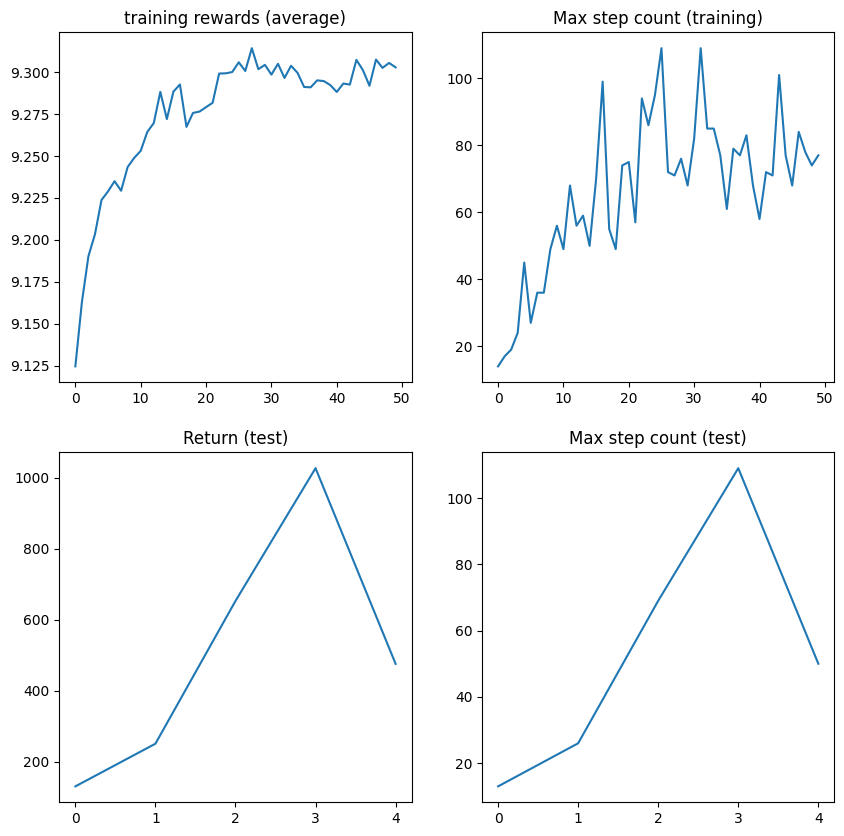

In [100]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()